# Project 2: Regression

## Backstory:

Using information we scrape from the web, build linear regression models from which we can learn about movies, *sports*, or categories.

In [49]:
from bs4 import BeautifulSoup
import time, os
import numpy as np
import pandas as pd
import random
# import requests # not needed, since we are using Selenium
from fake_useragent import UserAgent
from selenium import webdriver
# from selenium.webdriver.common.keys import Keys

In [60]:
# Set up Selenium
chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

# Set random user agent
ua = UserAgent()
user_agent = {'User-agent': ua.random}
print(user_agent)

# Load first ranking page:
driver = webdriver.Chrome(chromedriver)
url = "https://www.atptour.com/en/rankings/singles"
driver.get(url)

{'User-agent': 'Mozilla/5.0 (Windows NT 6.2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1464.0 Safari/537.36'}


### Overview rankings table scrape:

In [62]:
ranks=[]
players=[]
countries=[]
ages=[]
points=[]
tourns=[]
player_urls=[]

for i in range(0,4):
    suffix = [
        "", 
        "?rankDate=2020-09-28&rankRange=101-200", 
        "?rankDate=2020-09-28&rankRange=201-300", 
        "?rankDate=2020-09-28&rankRange=301-400"
    ]
    driver.get(url+suffix[i])
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    for element in soup.find_all('td', class_='rank-cell'):
        ranks.append(int(element.text.strip()))

    for element in soup.find_all('td', class_='player-cell'):
        players.append(element.text.strip('\n').lstrip())

    for element in soup.find_all('td', class_='country-cell'):
        countries.append(element.find('img').get('alt'))

    for element in soup.find_all('td', class_='age-cell'):
        ages.append(int(element.text.strip()))

    for element in soup.find_all('td', class_='points-cell'):
        points.append(element.text.strip())  

    for element in soup.find_all('td', class_='tourn-cell'):
        tourns.append(element.text.strip())

    for element in soup.find_all('td', class_='player-cell'):
        player_urls.append(element.find('a').get('href'))

In [63]:
tennis_dict = {'Rank':ranks, 'Name':players, 'Country':countries, 'Age':ages, "Points":points, "Tournaments":tourns, "URI":player_urls}
tennis_df = pd.DataFrame(tennis_dict)
tennis_df['Points'] = tennis_df['Points'].str.replace(',', '').astype(int)
tennis_df['Tournaments'] = tennis_df['Tournaments'].str.replace(',', '').astype(int)
print(tennis_df.shape)

tennis_df.head()

(400, 7)


,Rank,Name,Country,Age,Points,Tournaments,URI
0,1,Novak Djokovic,SRB,33,11260,18,/en/players/novak-djokovic/d643/overview
1,2,Rafael Nadal,ESP,34,9850,18,/en/players/rafael-nadal/n409/overview
2,3,Dominic Thiem,AUT,27,9125,21,/en/players/dominic-thiem/tb69/overview
3,4,Roger Federer,SUI,39,6630,16,/en/players/roger-federer/f324/overview
4,5,Daniil Medvedev,RUS,24,5890,24,/en/players/daniil-medvedev/mm58/overview


##### Per player data scrape:
(takes ~15 min on a low latency connection, randomized connection times)

In [53]:
list_of_dicts = []
dummy_dict = {'Aces': 0, 'Double Faults': 0, '1st Serve': 0.0, '1st Serve Points Won': 0.0, '2nd Serve Points Won': 0.0, 'Break Points Faced': 0, 'Break Points Saved': 0.0, 'Service Games Played': 0, 'Service Games Won': 0.0, 'Total Service Points Won': 0.0, '1st Serve Return Points Won': 0.0, '2nd Serve Return Points Won': 0.0, 'Break Points Opportunities': 0, 'Break Points Converted': 0.0, 'Return Games Played': 0, 'Return Games Won': 0.0, 'Return Points Won': 0.0, 'Total Points Won': 0.0, 'Year Turned Pro': 0, 'Career Wins': 0, 'Career Losses': 0, 'Career WL Ratio': 0.0, 'Lifetime Prize': 0}

In [58]:
first_run = True

for num in range(300,400):
    # Load URL in Selenium
    uri = "https://www.atptour.com"+player_urls[num].replace("overview", "player-stats")
    driver.get(uri)
    if first_run: # adds extra time for the first page load
        time.sleep(3) # note, you may be prompted to complete a CAPTCHA here
    else:
        time.sleep(0.5+1.5*random.random())
    
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    stats = {}
    
    try:
        # Scrape left-hand table
        table = soup.find('table', class_ = "mega-table")
        rows = [row for row in table.find_all('tr')]
        rows.pop(0) # removes table header
        
        for row in rows:
            items = row.find_all('td')
            if items[1].text.strip()[-1] == "%":
                stats[items[0].text.strip()] = float(int(items[1].text.strip().replace('%', ''))/100.0)
            else:
                stats[items[0].text.strip()] = int(items[1].text.strip().replace(',', ''))

        # Scrape right-hand table
        table = table.find_next_sibling()
        rows = [row for row in table.find_all('tr')]
        rows.pop(0) # Removes table header

        for row in rows:
            items = row.find_all('td')
            if items[1].text.strip()[-1] == "%":
                stats[items[0].text.strip()] = float(int(items[1].text.strip().replace('%', ''))/100.0)
            else:
                stats[items[0].text.strip()] = int(items[1].text.strip().replace(',', ''))

    except AttributeError:
        print("This page, "+ player_urls[num].replace("overview", "player-stats") +", can't be loaded right now.")
        list_of_dicts.append(dummy_dict) # append dummy on failure to keep row index in sync
        if soup.find('div', class_="container atp-header-container"):
            print("not waiting")
        else:
            print("Waiting for CAPTCHA")
            time.sleep(30)
        continue

    try:
        uri = "https://www.atptour.com"+player_urls[num].replace("player-stats", "overview")
        time.sleep(0.1+0.7*random.random())
        driver.get(uri)
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Scrape year turned pro
        cell = soup.find(text = "Turned Pro").parent.find_next_sibling()
        stats["Year Turned Pro"] = int(cell.text.strip())

        # Scrape WL and winnings stats
        row = soup.find('table', class_ = "players-stats-table").tbody.find_all('tr')[1]
        wins   = int(row.find_all('td')[2].find_all('div')[0].text.strip().split('-')[0])
        losses = int(row.find_all('td')[2].find_all('div')[0].text.strip().split('-')[1])

        stats["Career Wins"] = wins
        stats["Career Losses"] = losses
        stats["Career WL Ratio"] = float(wins/losses)

        life_winnings = row.find_all('td')[4].find_all('div')[0].text.strip()
        stats["Lifetime Prize"] = int(life_winnings.strip('$').replace(',', ''))
    
    except:
        print("This WL page, "+ player_urls[num] +", can't be loaded right now.")
        list_of_dicts.append(dummy_dict) # append dummy on failure to keep row index in sync
        if soup.find('div', class_="container atp-header-container"):
            print("not waiting")
        else:
            print("Waiting for CAPTCHA")
            time.sleep(30)
        continue

    first_run = False # reduces wait to random amount for runs after the first one

    list_of_dicts.append(stats)

This WL page, /en/players/pedro-sakamoto/sl94/overview, can't be loaded right now.
not waiting
This page, /en/players/michael-vrbensky/v0b2/player-stats, can't be loaded right now.
not waiting
This page, /en/players/andrea-vavassori/va08/player-stats, can't be loaded right now.
not waiting
This WL page, /en/players/jose-hernandez-fernandez/h896/overview, can't be loaded right now.
not waiting
This page, /en/players/alex-molcan/mv14/player-stats, can't be loaded right now.
not waiting
This WL page, /en/players/orlando-luz/lf26/overview, can't be loaded right now.
not waiting
This page, /en/players/javier-barranco-cosano/bv25/player-stats, can't be loaded right now.
not waiting
This page, /en/players/shintaro-imai/i330/player-stats, can't be loaded right now.
not waiting
This page, /en/players/giulio-zeppieri/z0a1/player-stats, can't be loaded right now.
not waiting
This page, /en/players/lukas-klein/ki63/player-stats, can't be loaded right now.
not waiting
This page, /en/players/harry-b

In [59]:
tennis_details_df = pd.DataFrame(list_of_dicts) # convert dicts into "stats/details" dataframe
print(tennis_details_df.shape)
tennis_details_df.tail()

(400, 23)


,Aces,Double Faults,1st Serve,1st Serve Points Won,2nd Serve Points Won,Break Points Faced,Break Points Saved,Service Games Played,Service Games Won,Total Service Points Won,...,Break Points Converted,Return Games Played,Return Games Won,Return Points Won,Total Points Won,Year Turned Pro,Career Wins,Career Losses,Career WL Ratio,Lifetime Prize
395,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0
396,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0
397,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0
398,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0
399,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0


In [65]:
# Merge overall leaderboard with columns from each player's individual stats page:
tennis_df = pd.concat([tennis_df, tennis_details_df], axis = 1)
tennis_df.tail()

,Rank,Name,Country,Age,Points,Tournaments,URI,Aces,Double Faults,1st Serve,...,Break Points Converted,Return Games Played,Return Games Won,Return Points Won,Total Points Won,Year Turned Pro,Career Wins,Career Losses,Career WL Ratio,Lifetime Prize
395,396,Maxime Chazal,FRA,27,95,26,/en/players/maxime-chazal/cd00/overview,0,0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0
396,397,Skander Mansouri,TUN,25,94,31,/en/players/skander-mansouri/ml73/overview,0,0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0
397,398,Tobias Simon,GER,29,94,40,/en/players/tobias-simon/sk51/overview,0,0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0
398,399,Michael Geerts,BEL,25,93,22,/en/players/michael-geerts/gg65/overview,0,0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0
399,400,Ronald Slobodchikov,RUS,26,93,31,/en/players/ronald-slobodchikov/so96/overview,0,0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0


In [66]:
# Check that we've converted all percentages to floats, and comma-delineated strings to ints:
print(tennis_df.isnull().sum().sum()) # If this equals 0, we're happy with our scrape.
# tennis_df.dropna(axis = 0) # Not needed for current scrape; only if NaNs present.
print(tennis_df.dtypes)

tennis_df.tail()

0
Rank                             int64
Name                            object
Country                         object
Age                              int64
Points                           int64
Tournaments                      int64
URI                             object
Aces                             int64
Double Faults                    int64
1st Serve                      float64
1st Serve Points Won           float64
2nd Serve Points Won           float64
Break Points Faced               int64
Break Points Saved             float64
Service Games Played             int64
Service Games Won              float64
Total Service Points Won       float64
1st Serve Return Points Won    float64
2nd Serve Return Points Won    float64
Break Points Opportunities       int64
Break Points Converted         float64
Return Games Played              int64
Return Games Won               float64
Return Points Won              float64
Total Points Won               float64
Year Turned Pro        

,Rank,Name,Country,Age,Points,Tournaments,URI,Aces,Double Faults,1st Serve,...,Break Points Converted,Return Games Played,Return Games Won,Return Points Won,Total Points Won,Year Turned Pro,Career Wins,Career Losses,Career WL Ratio,Lifetime Prize
395,396,Maxime Chazal,FRA,27,95,26,/en/players/maxime-chazal/cd00/overview,0,0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0
396,397,Skander Mansouri,TUN,25,94,31,/en/players/skander-mansouri/ml73/overview,0,0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0
397,398,Tobias Simon,GER,29,94,40,/en/players/tobias-simon/sk51/overview,0,0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0
398,399,Michael Geerts,BEL,25,93,22,/en/players/michael-geerts/gg65/overview,0,0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0
399,400,Ronald Slobodchikov,RUS,26,93,31,/en/players/ronald-slobodchikov/so96/overview,0,0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0


### Pickle the summary data (not per-year just yet):

In [67]:
tennis_df.to_pickle("./tennis-500.pkl")
# tennis_df=pd.read_pickle("./tennis-500.pkl")

In [68]:
tennis_df = tennis_df[(tennis_df != 0).all(1)] # Drop scraped rows that have no stats

,Rank,Name,Country,Age,Points,Tournaments,URI,Aces,Double Faults,1st Serve,...,Break Points Converted,Return Games Played,Return Games Won,Return Points Won,Total Points Won,Year Turned Pro,Career Wins,Career Losses,Career WL Ratio,Lifetime Prize
0,1,Novak Djokovic,SRB,33,11260,18,/en/players/novak-djokovic/d643/overview,5813,2438,0.65,...,0.44,12964,0.32,0.42,0.54,2003,924,188,4.914894,144159599
1,2,Rafael Nadal,ESP,34,9850,18,/en/players/rafael-nadal/n409/overview,3544,1856,0.68,...,0.45,13635,0.34,0.42,0.55,2001,992,201,4.935323,121044734
2,3,Dominic Thiem,AUT,27,9125,21,/en/players/dominic-thiem/tb69/overview,2522,1214,0.60,...,0.39,5411,0.24,0.38,0.51,2011,291,153,1.901961,26917393
3,4,Roger Federer,SUI,39,6630,16,/en/players/roger-federer/f324/overview,11344,2742,0.62,...,0.41,18229,0.27,0.40,0.54,1998,1242,271,4.583026,129946683
4,5,Daniil Medvedev,RUS,24,5890,24,/en/players/daniil-medvedev/mm58/overview,1727,772,0.59,...,0.41,2730,0.25,0.39,0.52,2014,146,83,1.759036,12144881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Jan Satral,CZE,30,105,26,/en/players/jan-satral/sk67/overview,26,13,0.58,...,0.43,51,0.18,0.34,0.49,2010,1,4,0.250000,358872
376,377,Uladzimir Ignatik,BLR,30,104,32,/en/players/uladzimir-ignatik/i236/overview,4,5,0.67,...,0.50,11,0.18,0.26,0.41,2007,13,16,0.812500,677266
378,379,Brydan Klein,GBR,30,103,28,/en/players/brydan-klein/k964/overview,80,60,0.58,...,0.44,159,0.16,0.33,0.47,2007,1,10,0.100000,707760
389,390,Adam Pavlasek,CZE,25,98,27,/en/players/adam-pavlasek/pg32/overview,99,46,0.61,...,0.47,188,0.20,0.35,0.48,2012,6,9,0.666667,669782


In [69]:
# Assume name as unique index
# Drop Country, URI, raw W and L, year turned pro; add years pro
tennis_df['Career Years'] = 2020 - tennis_df['Year Turned Pro']
tennis_df_subset = tennis_df.set_index("Name").drop(['Country', 'URI', 'Career Wins', 'Career Losses', 'Year Turned Pro'], axis = 1)
tennis_df_subset.head()
print(tennis_df_subset.dtypes)

Rank                             int64
Age                              int64
Points                           int64
Tournaments                      int64
Aces                             int64
Double Faults                    int64
1st Serve                      float64
1st Serve Points Won           float64
2nd Serve Points Won           float64
Break Points Faced               int64
Break Points Saved             float64
Service Games Played             int64
Service Games Won              float64
Total Service Points Won       float64
1st Serve Return Points Won    float64
2nd Serve Return Points Won    float64
Break Points Opportunities       int64
Break Points Converted         float64
Return Games Played              int64
Return Games Won               float64
Return Points Won              float64
Total Points Won               float64
Year Turned Pro                  int64
Career WL Ratio                float64
Lifetime Prize                   int64
Career Years             

### Time to get some year-over-year values:
(This is less data per page, so I'm trying to scrape a little faster here.)

In [ ]:
# 2016-2019 data: try/catch

# Sample URI:
# https://www.atptour.com/en/players/novak-djokovic/d643/player-stats?year=2016

# Two intra-year pairings are all that's needed, but there are lots of zeroes for which players didn't play or weren't ranked. Here we can have up to 3 intra-year consecutive pairings, for some, but not all ranked players.

driver = webdriver.Chrome(chromedriver)
list_of_dicts = []
first_run = True

for index, row in tennis_df.iterrows():
    uri = "https://www.atptour.com"+row['URI']
    player_name = row['Name']
    for year in range(2016,2020):
        # Load URL in Selenium
        uri_year = uri.replace("overview", "player-stats")+"?year="+str(year)
        driver.get(uri_year)
        if first_run: # adds extra time for the first page load
            time.sleep(30)
        else:
            time.sleep(0.15 + random.random())

        soup = BeautifulSoup(driver.page_source, 'html.parser')

        try:
            # Scrape left-hand table
            table = soup.find('table', class_ = "mega-table")
            rows = [row for row in table.find_all('tr')]
            rows.pop(0) # removes table header
            stats = {}
            stats['Name'] = player_name
            stats['Year'] = year

            for row in rows: # inner for loop to examine scrape dpage, not in parent df
                items = row.find_all('td')
                if items[1].text.strip()[-1] == "%":
                    stats[items[0].text.strip()] = float(int(items[1].text.strip().replace('%', ''))/100.0)
                else:
                    stats[items[0].text.strip()] = int(items[1].text.strip().replace(',', ''))

            # Scrape right-hand table
            table = table.find_next_sibling()
            rows = [row for row in table.find_all('tr')]
            rows.pop(0) # Removes table header

            for row in rows:
                items = row.find_all('td')
                if items[1].text.strip()[-1] == "%":
                    stats[items[0].text.strip()] = float(int(items[1].text.strip().replace('%', ''))/100.0)
                else:
                    stats[items[0].text.strip()] = int(items[1].text.strip().replace(',', ''))

        except AttributeError:
            print("Stats for "+ uri_year + " in "+str(year)+" can't be loaded right now.")
            # append something useful, maybe NANs here.

        if stats['Service Games Played'] != 0: # check if non-empty
            list_of_dicts.append(stats)

        first_run = False

In [ ]:
tennis_annual_df = pd.DataFrame(list_of_dicts) # convert dicts into "stats/details" dataframe
print(tennis_annual_df.shape)
zero_count = tennis_annual_df['Service Games Played'] == 0
zero_count.shape

In [71]:
# tennis_annual_df.to_pickle("./tennis_annual-500.pkl")

tennis_annual_df=pd.read_pickle("./tennis_annual-500.pkl")

### Visualize what we have so far:

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [75]:
# Prioritize Win/Loss ratio as the target column:

tennis_o_wlratio = tennis_df_subset[['Career WL Ratio','Points','Aces','Tournaments','Double Faults',
       '1st Serve', '1st Serve Points Won', '2nd Serve Points Won',
       'Break Points Faced', 'Break Points Saved', 'Service Games Played',
       'Service Games Won', 'Total Service Points Won',
       '1st Serve Return Points Won', '2nd Serve Return Points Won',
       'Break Points Opportunities', 'Break Points Converted',
       'Return Games Played', 'Return Games Won', 'Return Points Won',
       'Total Points Won', 'Career Years']]

# Prioritize lifetime Prize Money as the target column:
tennis_o_prize = tennis_df_subset[['Lifetime Prize','Points','Aces','Tournaments','Double Faults',
       '1st Serve', '1st Serve Points Won', '2nd Serve Points Won',
       'Break Points Faced', 'Break Points Saved', 'Service Games Played',
       'Service Games Won', 'Total Service Points Won',
       '1st Serve Return Points Won', '2nd Serve Return Points Won',
       'Break Points Opportunities', 'Break Points Converted',
       'Return Games Played', 'Return Games Won', 'Return Points Won',
       'Total Points Won', 'Career Years']]

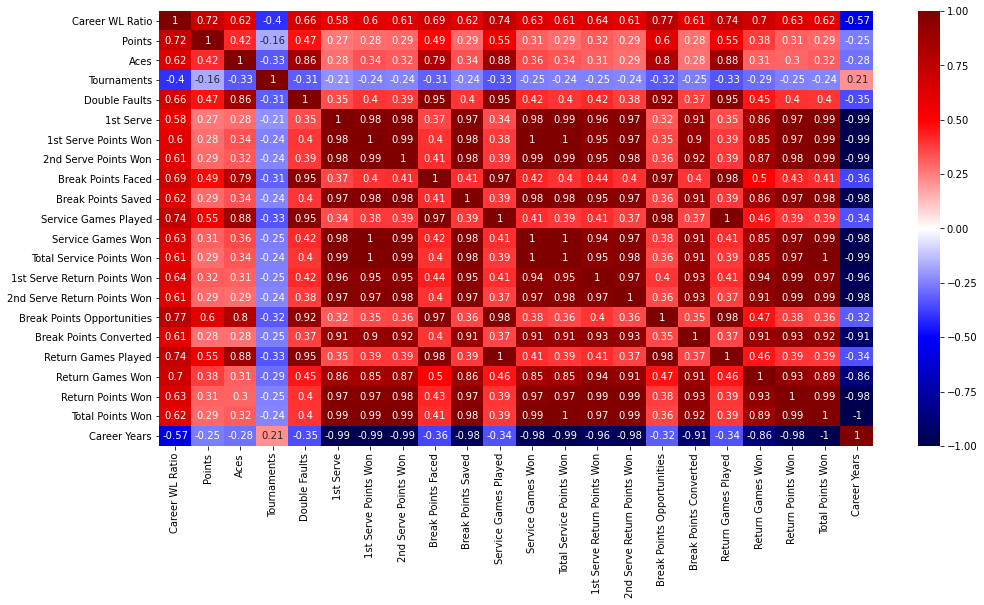

In [76]:
plt.figure(figsize=(16, 8))
sns.heatmap(tennis_o_wlratio.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

It's interesting how being in a tournament actually hurts WL ratio: the more challenging tournaments a player enters, the more he's likely to lose.

In [77]:
# Let's try a 0.55 threshold for using features:
print(tennis_o_wlratio.corr()['Career WL Ratio'].sort_values(ascending = False))

Career WL Ratio                1.000000
Break Points Opportunities     0.767088
Service Games Played           0.739603
Return Games Played            0.737084
Points                         0.715562
Return Games Won               0.698394
Break Points Faced             0.689737
Double Faults                  0.659924
1st Serve Return Points Won    0.635803
Return Points Won              0.631363
Service Games Won              0.631255
Break Points Saved             0.623487
Aces                           0.619059
Total Points Won               0.616281
2nd Serve Points Won           0.613778
2nd Serve Return Points Won    0.613701
Break Points Converted         0.609948
Total Service Points Won       0.608868
1st Serve Points Won           0.601791
1st Serve                      0.576678
Tournaments                   -0.398807
Career Years                  -0.566797
Name: Career WL Ratio, dtype: float64


In [16]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(tennis_o_wlratio, height=6, aspect=1.5);
# Service games played and aces have higher variability

### First attempt at linear regression with scikit-learn:

In [75]:
import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LinearRegression

%matplotlib inline

tennis_o_wlratio.columns

Index(['Career WL Ratio', 'Points', 'Aces', 'Tournaments', 'Double Faults',
       '1st Serve', '1st Serve Points Won', '2nd Serve Points Won',
       'Break Points Faced', 'Break Points Saved', 'Service Games Played',
       'Service Games Won', 'Total Service Points Won',
       '1st Serve Return Points Won', '2nd Serve Return Points Won',
       'Break Points Opportunities', 'Break Points Converted',
       'Return Games Played', 'Return Games Won', 'Return Points Won',
       'Total Points Won'],
      dtype='object')

In [108]:
# Create an empty model
lr = LinearRegression()

"""
Career WL Ratio                1.000000
Total Points Won               0.859081
Points                         0.822180
Break Points Opportunities     0.761501
Service Games Played           0.693459
Return Games Played            0.686703
2nd Serve Points Won           0.576420
Break Points Faced             0.561890
Aces                           0.544893
Tournaments                   -0.575555
"""

# Choose the response variable (will try others after)
X = tennis_o_wlratio.loc[:, ['Total Points Won', 'Points', 'Break Points Opportunities', 'Service Games Played', '2nd Serve Points Won', 'Break Points Faced', 'Aces', 'Tournaments', 'Career Years']]
y = tennis_o_wlratio['Career WL Ratio']

lr.fit(X, y)

# Score
print("R^2: " + str(lr.score(X, y)))

R^2: 0.8718225576207833


### Now with statsmodels:

In [109]:
sm.add_constant(X).head()
#Create the model
model = sm.OLS(y, sm.add_constant(X)) 
#Fit
fit = model.fit()
#Print out summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Career WL Ratio   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     294.7
Date:                Fri, 09 Oct 2020   Prob (F-statistic):          6.06e-168
Time:                        00:24:21   Log-Likelihood:                 11.770
No. Observations:                 400   AIC:                            -3.540
Df Residuals:                     390   BIC:                             36.37
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -3.0513      0.371     -8.223      0.000      -3.781      -2.322
Total Points Won               7.8461      0.873      8.983      0.000       6.129       9.563
Points                         0.0001   1.63e-05      6.703      0.000    7.74e-05       0.000
Break Points Opportunities     0.0006   8.15e-05      6.951      0.000       0.000       0.001
Service Games Played       -9.258e-05   9.33e-05     -0.992      0.322      -0.000    9.09e-05
2nd Serve Points Won           0.2202      0.489      0.450      0.653      -0.742       1.182
Break Points Faced            -0.0004   7.66e-05     -5.036      0.000      -0.001      -0.000
Aces                        4.607e-05   3.96e-05      1.164      0.245   -3.18e-05       0.000
Tournaments                   -0.0085      0.002     -3.806      0.000      -0.013      -0.004
Career Years                   0.0016      0.000      9.257      0.000       0.001       0.002
==============================================================================
Omnibus:                       99.786   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              438.962
Skew:                           1.008   Prob(JB):                     4.79e-96
Kurtosis:                       7.719   Cond. No.                     3.43e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

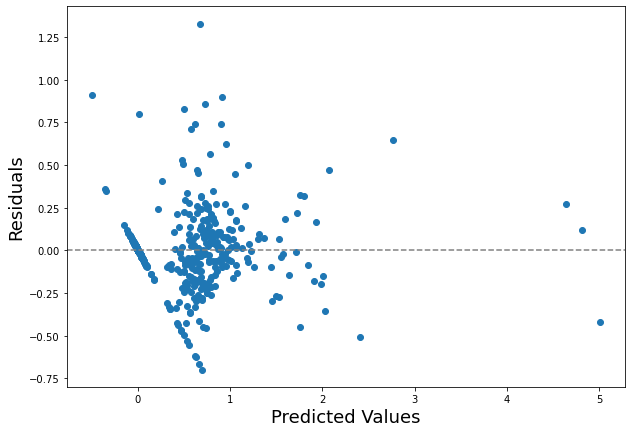

In [135]:
plt.figure(figsize=(10, 7))
plt.scatter(fit.predict(), fit.resid)    #change this if working with sklearn

plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Residuals', fontsize=18);

Pretty good! But I think we can do better.

### Let's split up our train-test-eval split:

In [117]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

# X, y = tennis_o_wlratio.drop('Career WL Ratio',axis=1), tennis_o_wlratio['Career WL Ratio']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [118]:
kf = KFold(n_splits=4, shuffle=True, random_state = 12)
cv_lm_r2s, cv_lm_reg_r2s, cv_lm_lasso = [], [], [] #collect the validation results for both models

#rmse = sqrt(mean_squared_error(y_true=y_val, y_pred=lr_model.predict(X_val)))

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)
    lm_cv = LassoCV(cv=kf)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge and lasso require feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    #ridge
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
    
    #lasso
    lm_cv.fit(X_train_scaled, y_train)
    cv_lm_lasso.append(lm_cv.score(X_val_scaled, y_val))
    print(lm_cv.coef_, lm_cv.alpha_, '\n')
    print(lm_cv.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s)
print('Lasso scores: ', cv_lm_lasso, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'Lasso mean cv r^2: {np.mean(cv_lm_lasso):.3f} +- {np.std(cv_lm_lasso):.3f}')

[ 1.37612651  0.20283822  0.53159814 -0.31706796 -0.0444355   1.11092186] 0.0005689627698079931 

0.8524222573131626
[ 2.00614496  0.09793164  0.8692083  -0.65220254 -0.06033777  1.70490102] 0.0005156987951549023 

0.8779945003387856
[ 1.58306247  0.13279925  0.87208041 -0.60245453 -0.07151075  1.30175215] 0.0005829154297424186 

0.7792611571989727
[ 1.12553631  0.07890118  0.74840394 -0.4860395  -0.08059054  0.83654885] 0.0015560317881997496 

0.9015508853994635
Simple regression scores:  [0.8634705940506353, 0.8680673865526556, 0.7794298347763401, 0.9106263573957198]
Ridge scores:  [0.807641952227299, 0.9070351533725964, 0.7578101167615117, 0.8922379018349454]
Lasso scores:  [0.8524222573131626, 0.8779945003387856, 0.7792611571989727, 0.9015508853994635] 

Simple mean cv r^2: 0.855 +- 0.048
Ridge mean cv r^2: 0.841 +- 0.061
Lasso mean cv r^2: 0.853 +- 0.046


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012913291224140977, tolerance: 0.008451624575584654
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03311386571683528, tolerance: 0.008474190495877125
  model = cd_fast.enet_coordinate_descent(


OK cool, slight improvement.
### Let's remove the one zeroed feature:

In [140]:
X = tennis_o_wlratio.loc[:, ['Total Points Won', 'Points', 'Break Points Opportunities', 'Break Points Faced', 'Tournaments']]
y = tennis_o_wlratio['Career WL Ratio']

In [141]:
# X, y = tennis_o_wlratio.drop('Career WL Ratio',axis=1), tennis_o_wlratio['Career WL Ratio']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

kf = KFold(n_splits=4, shuffle=True, random_state = 12)
cv_lm_r2s, cv_lm_reg_r2s, cv_lm_lasso = [], [], [] #collect the validation results for both models
cv_lr_rmse, cv_ridge_rmse, cv_lasso_rmse = [], [], [] #collect the validation results for both models

#rmse = sqrt(mean_squared_error(y_true=y_val, y_pred=lr_model.predict(X_val)))

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)
    lm_cv = LassoCV(cv=kf)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    cv_lr_rmse.append(np.sqrt(mean_squared_error(y_train, lm.predict(X_train))))
    
    #ridge and lasso require feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    #ridge
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
    cv_ridge_rmse.append(np.sqrt(mean_squared_error(y_train, lm_reg.predict(X_train_scaled))))
    
    #lasso
    lm_cv.fit(X_train_scaled, y_train)
    cv_lm_lasso.append(lm_cv.score(X_val_scaled, y_val))
    cv_lasso_rmse.append(np.sqrt(mean_squared_error(y_train, lm_cv.predict(X_train_scaled))))
    print(lm_cv.coef_, lm_cv.alpha_)
    print(lm_cv.score(X_val_scaled, y_val), '\n')

print('Simple regression R^2 scores: ', cv_lm_r2s)
print('Ridge R^2 scores: ', cv_lm_reg_r2s)
print('Lasso R^2 scores: ', cv_lm_lasso, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'Lasso mean cv r^2: {np.mean(cv_lm_lasso):.3f} +- {np.std(cv_lm_lasso):.3f}')

print('Simple regression RMSE scores: ', cv_lr_rmse)
print('Ridge RMSE scores: ', cv_ridge_rmse)
print('Lasso RMSE scores: ', cv_lasso_rmse, '\n')

print(f'Simple mean cv RMSE: {np.mean(cv_lr_rmse):.3f} +- {np.std(cv_lr_rmse):.3f}')
print(f'Ridge mean cv RMSE: {np.mean(cv_ridge_rmse):.3f} +- {np.std(cv_ridge_rmse):.3f}')
print(f'Lasso mean cv RMSE: {np.mean(cv_lasso_rmse):.3f} +- {np.std(cv_lasso_rmse):.3f}')

[ 0.26866303  0.14859246  0.59471585 -0.38685137 -0.04254413] 0.00041398774060161524
0.8423974855932059 

[ 0.24903293  0.1571097   0.72773789 -0.42096872 -0.08146368] 0.002891208054669811
0.8055556709484615 

[ 0.24168791  0.14452438  0.70099359 -0.37094094 -0.0990475 ] 0.002978484701210907
0.7537131765775564 

[ 0.26467214  0.13764469  0.82936961 -0.57708863 -0.09212136] 0.0004741303338622244
0.821674457976326 

Simple regression R^2 scores:  [0.8442645126901042, 0.8054039048910474, 0.7614371960106501, 0.8198760940860905]
Ridge R^2 scores:  [0.8360641631264283, 0.8066215104173691, 0.7573007140860069, 0.8237103112287909]
Lasso R^2 scores:  [0.8423974855932059, 0.8055556709484615, 0.7537131765775564, 0.821674457976326] 

Simple mean cv r^2: 0.808 +- 0.030
Ridge mean cv r^2: 0.806 +- 0.030
Lasso mean cv r^2: 0.806 +- 0.033
Simple regression RMSE scores:  [0.2346732324173787, 0.2616493272959851, 0.262022443015583, 0.2445907797912906]
Ridge RMSE scores:  [0.23530208027079408, 0.2624940921

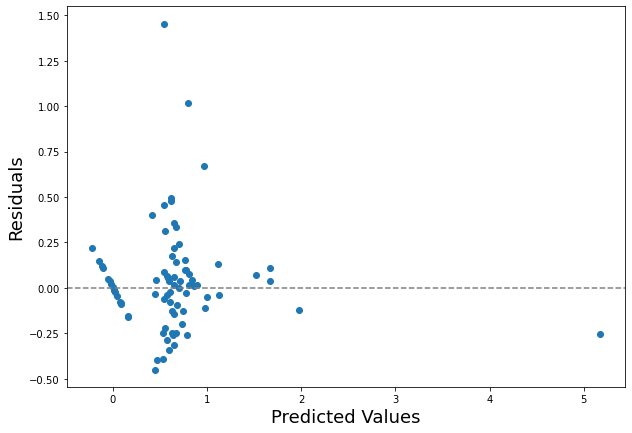

In [142]:
prediction = lm.predict(X_test)
residual = (y_test - prediction)
plt.figure(figsize=(10, 7))
plt.scatter(prediction, residual)    #change this if working with sklearn

plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Residuals', fontsize=18);

### And for some visualizations:

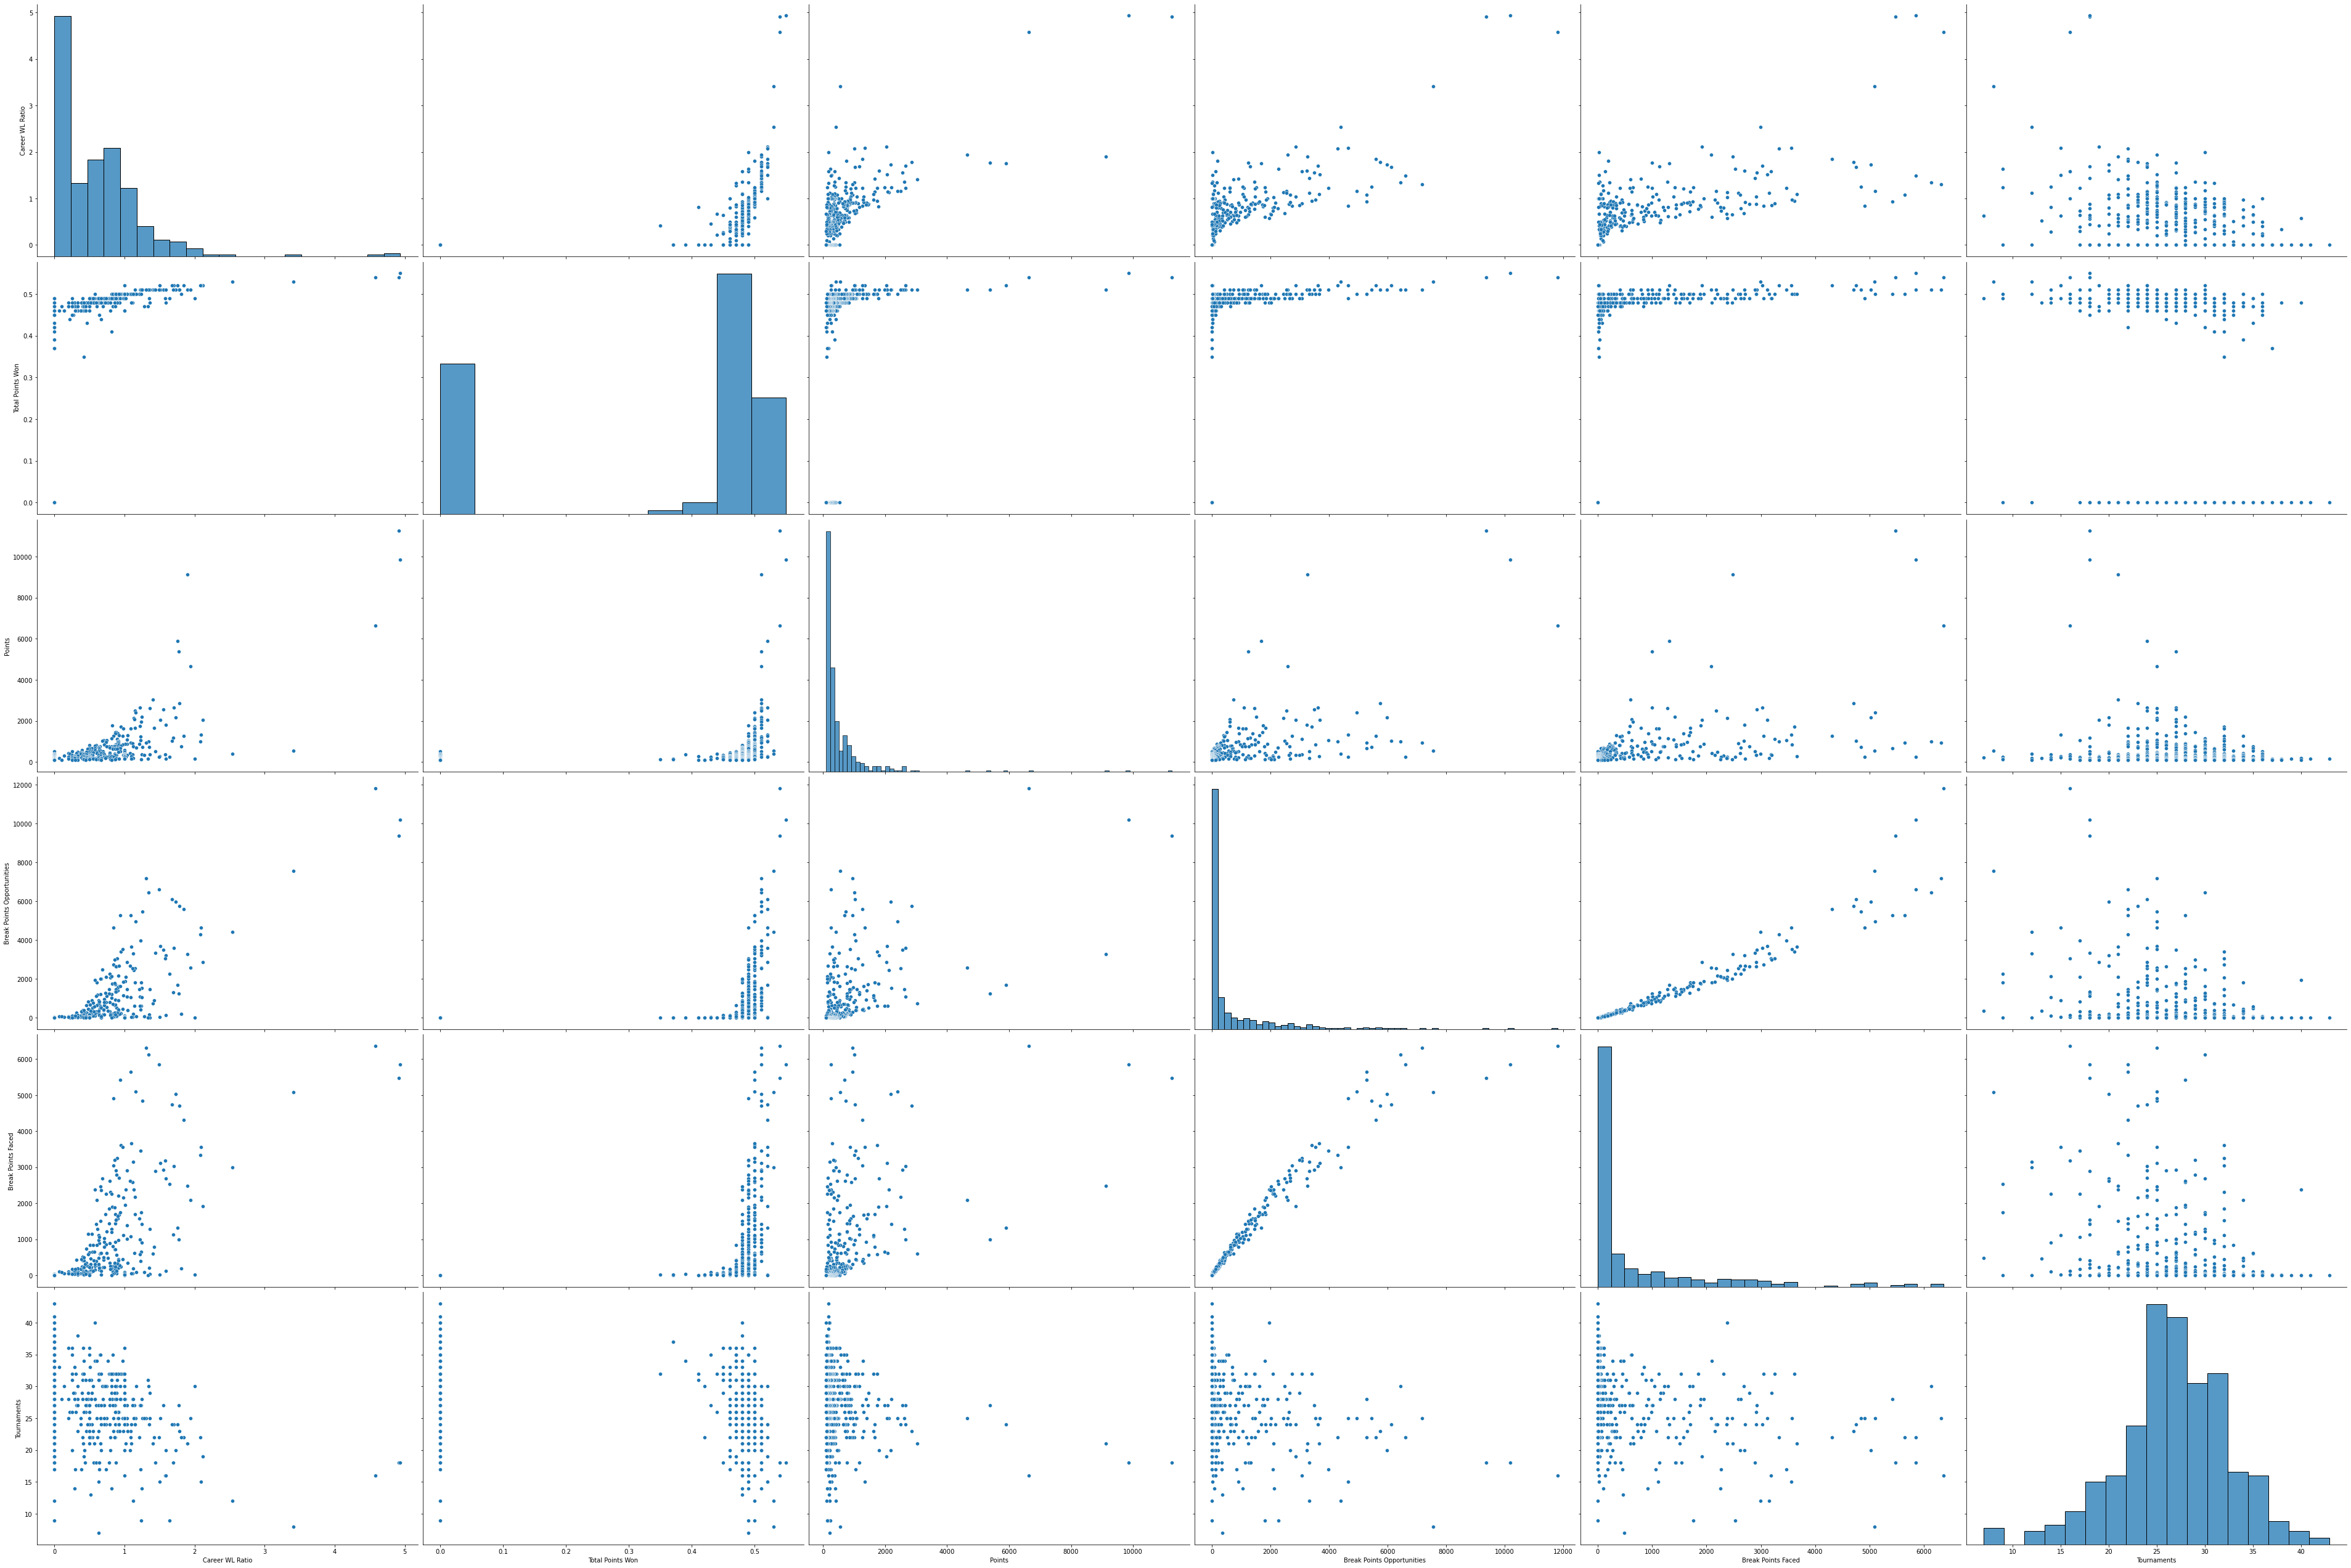

In [136]:
#Charts
corr_df = tennis_o_wlratio[['Career WL Ratio','Total Points Won', 'Points', 'Break Points Opportunities', 'Break Points Faced', 'Tournaments']]
sns.pairplot(corr_df, height=6, aspect=1.5);

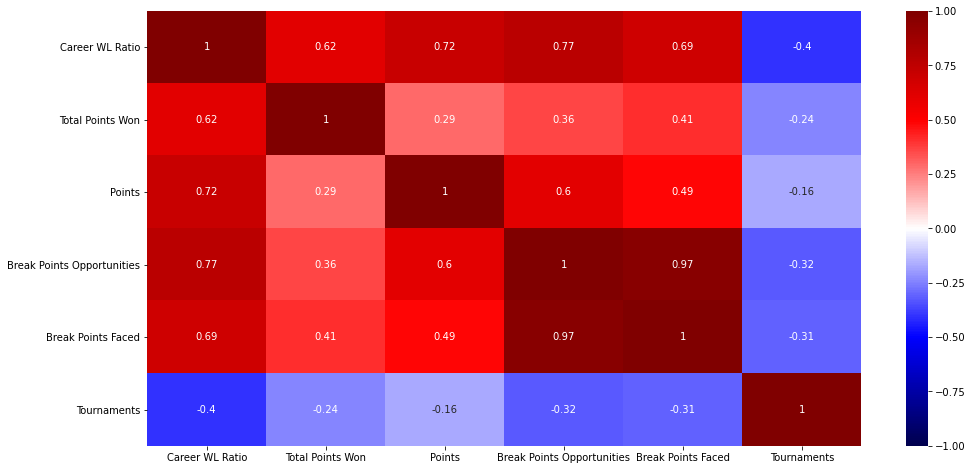

In [137]:
plt.figure(figsize=(16, 8))
sns.heatmap(corr_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

## Deliverable/communication:

 * organized project repository
 * slide presentation
 * visual and oral communication in presentations
 * write-up of process and results

### Design:

 * iterative design process
 * "MVP"s and building outward
 * [stand-ups/scrums](https://en.wikipedia.org/wiki/Scrum_(software_development)) (1 minute progress updates to the class)